# Produce regional figures
The following script is used to identify stations within a specific geographic region (counties, spatial extent) and produce simple maps of their location. These can be produced for one-off requests. 
Examples:
- Santa Clara subset for precipitation sensors, for VW
- San Diego subset for hypothetical station replacement, for CEC

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
from pyproj import CRS, Transformer

%matplotlib inline

In [2]:
# Helper function for plotting
def latlon_to_mercator_cartopy(lat, lon):
    proj_latlon = CRS('EPSG:4326')
    proj_mercator = CRS('EPSG:3857')
    
    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x,y = transformer.transform(lon, lat)
    
    return x, y

# Shapefile of CA counties, for subsetting for a specific area
ca_counties = gpd.read_file("s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp" )

In [3]:
# Read in all stations
df_all = pd.read_csv("s3://wecc-historical-wx/2_clean_wx/temp_clean_all_station_list.csv")

# Subset for cleaned stations (Y flag)
df_clean = df_all.loc[df_all['cleaned'] == 'Y']

#### Example of subsetting for a variable + region
Looking at stations in the Santa Clara region for precipitation sensors

In [4]:
# Pick specific county
target_county = ca_counties[ca_counties['NAME'] == 'Santa Clara']

In [5]:
# Identify stations with precipitation sensors, looking for sensors with more than 5 observations to avoid stations that have a single observation
df_clean_pr = df_clean.loc[(df_clean[['pr_nobs', 'pr_5min_nobs', 'pr_1h_nobs', 'pr_24h_nobs', 'pr_localmid_nobs']] > 5).any(axis=1)]

# Option to output the subsetted stations with precip
#df_clean_pr.to_csv('histobs_stns_all_precip.csv')

In [6]:
# Set up a map
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (df_clean.latitude, df_clean.longitude)]
pr_stns = gpd.GeoDataFrame(df_clean, geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column
pr_stns = gpd.overlay(pr_stns, target_county, how="intersection") # subsetting for stations within county boundaries
print(f'Number of stations: {len(pr_stns)}')

Number of stations: 206


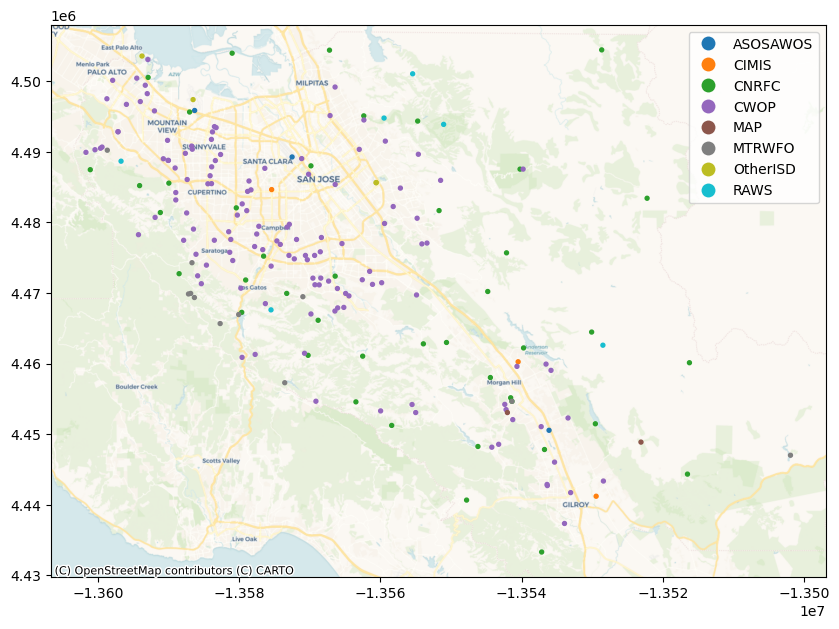

In [7]:
# Mapping
ax = pr_stns.plot(column='network', markersize=8, legend=True, figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

# Also, can use your geodataframe and .explore() to zoom around
# pr_stns.explore()

#### Example of subsetting for a specific region + network
Looking at sensors in San Diego county, and specific networks

In [8]:
# Pick specific county
target_county = ca_counties[ca_counties['NAME'] == 'San Diego']

In [9]:
# Subset for those stations
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (df_clean.latitude, df_clean.longitude)]
sd_stns = gpd.GeoDataFrame(df_clean, geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column
sd_stns = gpd.overlay(sd_stns, target_county, how="intersection") # subsetting for stations within county boundaries
print(f'Number of stations: {len(sd_stns)}')

# Option to export 
#sd_stns.to_csv('histobs_stns_san_diego_county.csv')

Number of stations: 521


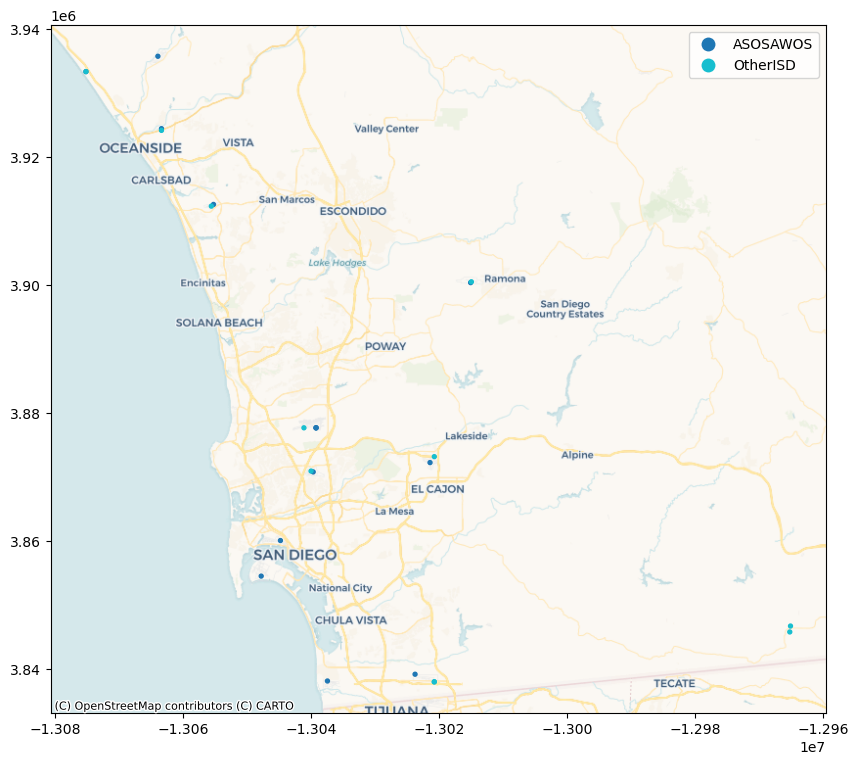

In [10]:
# Subset for specific network
sd_stns_network_subset = sd_stns.loc[(sd_stns['network'] == 'OtherISD') | (sd_stns['network'] == 'ASOSAWOS')]

# Mapping
ax = sd_stns_network_subset.plot(column='network', markersize=8, legend=True, figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)